# Market Risk Module — VaR & Expected Shortfall (Historical & Parametric)

**Focus:** Estimate and backtest **Value at Risk (VaR)** and **Expected Shortfall (ES)** using both **historical** and **parametric** approaches. Compute portfolio VaR at multiple confidence levels, visualise tail behaviour, and relate results to **Basel FRTB** concepts, including the role of stress testing in capital planning.

## Learning Objectives
- Build a simple portfolio and compute **P&L** from returns.
- Estimate **Historical VaR/ES** and **Parametric VaR/ES** (Gaussian, Student‑t, and EWMA / RiskMetrics variance).
- **Backtest VaR** using the **Kupiec POF** and optional **Christoffersen independence** tests.
- Visualise loss tails and discuss links to **FRTB** (e.g., ES at 97.5%, modellability, stress testing).

## Setup

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from math import sqrt
from scipy.stats import norm, t as student_t, chi2

pd.set_option('display.float_format', lambda x: f'{x:,.6f}')
rng = np.random.default_rng(123)


## Data — Use Your Own or Simulate
Set `USE_SIMULATED = False` and provide a CSV with columns of **daily returns** (in decimals), or keep `True` to simulate. Provide a weight vector for the portfolio.

In [14]:
USE_SIMULATED = True
DATA_PATH = Path('returns.csv')  # if using your own data: columns = assets, rows = dates; values = daily returns in decimals

# Portfolio weights (sum to 1)
weights = np.array([0.4, 0.4, 0.2])


### Load or Simulate Returns

In [15]:
if USE_SIMULATED:
    n = 1500  # ~6 years of trading days
    # Simulate 3-asset correlated Student-t returns (fat tails)
    corr = np.array([[1.0, 0.3, 0.1], [0.3, 1.0, 0.2], [0.1, 0.2, 1.0]])
    vols = np.array([0.012, 0.016, 0.02])  # daily vol
    L = np.linalg.cholesky(corr)
    nu = 5  # degrees of freedom
    z = rng.standard_normal((n, 3))
    chi = rng.chisquare(nu, size=(n, 1)) / nu
    t_vars = (z / np.sqrt(chi)) @ L.T
    ret = t_vars * vols
    dates = pd.bdate_range('2018-01-01', periods=n)
    df_ret = pd.DataFrame(ret, index=dates, columns=['A','B','C'])
else:
    df_ret = pd.read_csv(DATA_PATH, index_col=0)
    df_ret.index = pd.to_datetime(df_ret.index)

# Align weights to columns if needed
if len(weights) != df_ret.shape[1]:
    weights = np.ones(df_ret.shape[1]) / df_ret.shape[1]

weights = weights / weights.sum()
df_ret.head()


,A,B,C
2018-01-01,-0.013477,-0.011764,0.024894
2018-01-02,0.003099,0.019941,0.019927
2018-01-03,-0.007431,0.005076,-0.005390
2018-01-04,-0.004988,-0.000083,-0.038907
2018-01-05,0.011845,-0.003743,0.016208


## Portfolio P&L

In [16]:
port_ret = (df_ret.values @ weights).flatten()
pnl = pd.Series(port_ret, index=df_ret.index, name='P&L')
pnl.describe()


count   1,500.000000
mean        0.000178
std         0.013724
min        -0.059358
25%        -0.007288
50%         0.000260
75%         0.008088
max         0.093196
Name: P&L, dtype: float64

## VaR & ES Functions

In [17]:
def hist_var(pnl: pd.Series, alpha: float) -> float:
    # Loss is -P&L; VaR is positive loss threshold
    return np.quantile(-pnl.dropna(), alpha)

def hist_es(pnl: pd.Series, alpha: float) -> float:
    losses = -pnl.dropna()
    q = np.quantile(losses, alpha)
    tail = losses[losses >= q]
    return tail.mean() if len(tail) else q

def gauss_var_es(pnl: pd.Series, alpha: float) -> tuple:
    mu = pnl.mean()
    sigma = pnl.std(ddof=1)
    z = norm.ppf(alpha)
    var = -(mu - z*sigma)
    # ES for normal: sigma * phi(z)/(1-alpha) - mu
    es = -(mu - sigma * (norm.pdf(z)/(1-alpha)))
    return float(var), float(es)

def t_var_es(pnl: pd.Series, alpha: float, nu: int = 5) -> tuple:
    mu = pnl.mean()
    sigma = pnl.std(ddof=1)
    t_q = student_t.ppf(alpha, df=nu)
    var = -(mu - sigma * t_q * sqrt((nu-2)/nu))
    # ES for Student-t
    c = (student_t.pdf(t_q, df=nu) * (nu + t_q**2)) / ((nu-1) * (1-alpha))
    es = -(mu - sigma * sqrt((nu-2)/nu) * c)
    return float(var), float(es)

def ewma_vol(pnl: pd.Series, lam: float = 0.94) -> pd.Series:
    x = pnl.values
    s2 = np.zeros_like(x)
    s2[0] = x[:50].var() if len(x) > 50 else x.var()
    for i in range(1, len(x)):
        s2[i] = lam*s2[i-1] + (1-lam)*x[i-1]**2
    return pd.Series(np.sqrt(s2), index=pnl.index)


## Point Estimates at Multiple Confidence Levels

In [18]:
levels = [0.95, 0.99, 0.995, 0.9975]
rows = []
for a in levels:
    hvar = hist_var(pnl, a)
    hes = hist_es(pnl, a)
    gvar, ges = gauss_var_es(pnl, a)
    tvar, tes = t_var_es(pnl, a, nu=5)
    rows.append({'Level': a, 'Hist VaR': hvar, 'Hist ES': hes, 'Gaussian VaR': gvar, 'Gaussian ES': ges, 't(5) VaR': tvar, 't(5) ES': tes})
point_df = pd.DataFrame(rows).set_index('Level')
point_df


,Hist VaR,Hist ES,Gaussian VaR,Gaussian ES,t(5) VaR,t(5) ES
Level,,,,,,
0.950000,0.021027,0.031660,0.022396,0.028131,0.021244,0.030546
0.990000,0.039312,0.044812,0.031749,0.036400,0.035594,0.047154
0.995000,0.045148,0.048177,0.035173,0.039512,0.042687,0.055633
0.997500,0.046062,0.050694,0.038346,0.042427,0.050566,0.065164


### Visualise Loss Tail

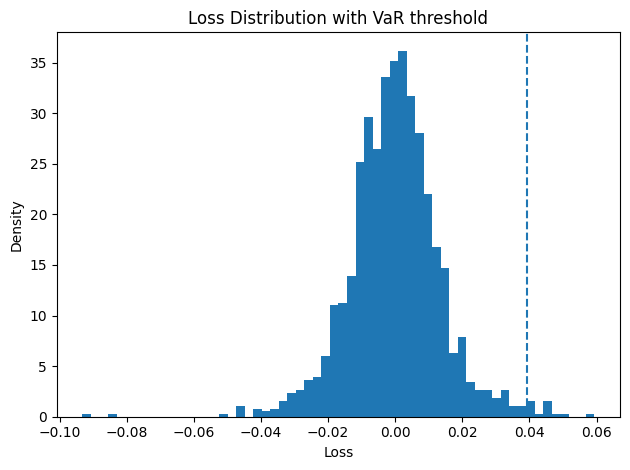

In [19]:
losses = -pnl
alpha = 0.99
q = np.quantile(losses, alpha)
plt.figure()
plt.hist(losses, bins=60, density=True)
plt.axvline(q, linestyle='--')
plt.title('Loss Distribution with VaR threshold')
plt.xlabel('Loss')
plt.ylabel('Density')
plt.tight_layout()
plt.show()


## Backtesting VaR (Rolling)

In [20]:
alpha_bt = 0.99
window = 250  # 1y lookback

# Historical rolling VaR
hist_roll = pnl.rolling(window).apply(lambda x: np.quantile(-x, alpha_bt), raw=False)

# EWMA Gaussian rolling VaR
lam = 0.94
ewma_sigma = ewma_vol(pnl, lam=lam)
gauss_roll = -(pnl.rolling(window).mean() - norm.ppf(alpha_bt)*ewma_sigma)

# Realised exceptions (loss > VaR)
exc_hist = (-pnl > hist_roll)
exc_gauss = (-pnl > gauss_roll)

bt_df = pd.DataFrame({
    'P&L': pnl,
    'Hist_VaR': hist_roll,
    'EWMA_Gauss_VaR': gauss_roll,
    'Exc_Hist': exc_hist,
    'Exc_Gauss': exc_gauss,
}).dropna()
bt_df.tail()


,P&L,Hist_VaR,EWMA_Gauss_VaR,Exc_Hist,Exc_Gauss
2023-09-25,0.001842,0.039445,0.034018,False,False
2023-09-26,0.006466,0.039445,0.032940,False,False
2023-09-27,-0.007306,0.039445,0.032112,False,False
2023-09-28,0.011442,0.039445,0.031302,False,False
2023-09-29,-0.002241,0.039445,0.031021,False,False


### Plot Rolling P&L and VaR (Example: EWMA Gaussian)

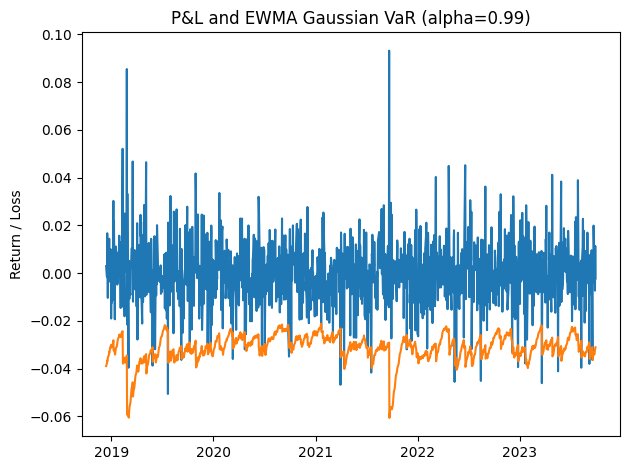

In [21]:
sub = bt_df[['P&L','EWMA_Gauss_VaR']].dropna()
plt.figure()
plt.plot(sub.index, sub['P&L'])
plt.plot(sub.index, -sub['EWMA_Gauss_VaR'])
plt.title('P&L and EWMA Gaussian VaR (alpha=0.99)')
plt.ylabel('Return / Loss')
plt.tight_layout()
plt.show()


### Kupiec POF and Christoffersen Tests

In [22]:
def kupiec_pof_test(exceed: pd.Series, alpha: float) -> dict:
    x = int(exceed.sum())
    n = int(exceed.count())
    pi = x / n
    # Likelihood ratio for unconditional coverage
    LR = -2 * ( (n - x) * np.log((1 - alpha) / (1 - pi + 1e-12)) + x * np.log(alpha / (pi + 1e-12)) )
    pval = 1 - chi2.cdf(LR, df=1)
    return {'exceptions': x, 'n': n, 'LR_pof': LR, 'p_value': pval}

def christoffersen_independence_test(exceed: pd.Series) -> dict:
    e = exceed.astype(int).values
    n00 = n01 = n10 = n11 = 0
    for i in range(1, len(e)):
        a, b = e[i-1], e[i]
        if a==0 and b==0: n00 += 1
        if a==0 and b==1: n01 += 1
        if a==1 and b==0: n10 += 1
        if a==1 and b==1: n11 += 1
    pi01 = n01 / max(n00 + n01, 1)
    pi11 = n11 / max(n10 + n11, 1)
    pi = (n01 + n11) / max(n00 + n01 + n10 + n11, 1)
    # LR for independence
    L0 = ((1-pi)**(n00+n10)) * (pi**(n01+n11))
    L1 = ((1-pi01)**n00) * (pi01**n01) * ((1-pi11)**n10) * (pi11**n11)
    LR = -2 * np.log((L0 + 1e-300)/(L1 + 1e-300))
    pval = 1 - chi2.cdf(LR, df=1)
    return {'n00': n00, 'n01': n01, 'n10': n10, 'n11': n11, 'LR_ind': LR, 'p_value': pval}

bt_stats = pd.DataFrame({
    'Hist_POF': kupiec_pof_test(bt_df['Exc_Hist'], alpha_bt),
    'GaussEWMA_POF': kupiec_pof_test(bt_df['Exc_Gauss'], alpha_bt),
    'Hist_Ind': christoffersen_independence_test(bt_df['Exc_Hist']),
    'GaussEWMA_Ind': christoffersen_independence_test(bt_df['Exc_Gauss']),
}).T
bt_stats


,exceptions,n,LR_pof,p_value,n00,n01,n10,n11,LR_ind
Hist_POF,12.000000,"1,251.000000","11,276.445402",0.000000,NaN,NaN,NaN,NaN,NaN
GaussEWMA_POF,29.000000,"1,251.000000","10,979.961016",0.000000,NaN,NaN,NaN,NaN,NaN
Hist_Ind,NaN,NaN,NaN,0.629575,"1,226.000000",12.000000,12.000000,0.000000,0.232637
GaussEWMA_Ind,NaN,NaN,NaN,0.702492,"1,193.000000",28.000000,28.000000,1.000000,0.145892


## FRTB Context: ES at 97.5% (Illustration)

In [23]:
alpha_frtb = 0.975
hvar_frtb = hist_var(pnl, alpha_frtb)
hes_frtb = hist_es(pnl, alpha_frtb)
gvar_frtb, ges_frtb = gauss_var_es(pnl, alpha_frtb)
pd.DataFrame({'Metric': ['VaR','ES'], 'Historical': [hvar_frtb, hes_frtb], 'Gaussian': [gvar_frtb, ges_frtb]}).set_index('Metric')


,Historical,Gaussian
Metric,,
VaR,0.029282,0.026721
ES,0.038164,0.031907


---
### Notes & Links to FRTB
- Under **FRTB**, capital is based on **Expected Shortfall at 97.5%**, calibrated to stress; modellability and the internal model approach (IMA) include **backtesting** and **P&L attribution** tests.
- This notebook demonstrates ES and VaR estimation methods and simple backtests; institutional implementations must follow regulatory data, modellability, and governance requirements.
- Stress testing market exposures (e.g., shocked risk factors) helps **capital planning** by linking tail loss potential to buffers.


## Export Key Tables

In [25]:

point_df.to_csv('market_risk_point_estimates.csv')
bt_df[['P&L','Hist_VaR','EWMA_Gauss_VaR']].to_csv( 'market_risk_backtest_series.csv')
bt_stats.to_csv('market_risk_backtest_stats.csv')
str(out_dir)


'/mnt/data'